# Battle of Poets

### Requirements for running this notebook
1. Mentioned modules in the below cell
2. [Dataset of Poems](https://www.kaggle.com/datasets/ultrajack/modern-renaissance-poetry)

Note that the aim of this notebook is just to understand the implementations used

In [1]:
import io
import math
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import torch
import random
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast, BertTokenizerFast, BartTokenizerFast, RobertaTokenizer
from torch.nn import Module, Dropout, Linear, MultiheadAttention, ReLU, LayerNorm, Embedding, Softmax, CrossEntropyLoss, TransformerEncoderLayer, TransformerEncoder, LSTM
from tempfile import TemporaryDirectory
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available and to be used : ", device)

Device available and to be used :  cuda


### PreProcessing
Here we obtain the poems from the csv and convert it into a tensor of continuous stream of data for training.
**NOTE**: We only consider a small amount of data, as it might be possible(as observed from previous experimenation) that the model is not deep enough to understand all of the poems.

In [2]:
poem_data = pd.read_csv('/kaggle/input/modern-renaissance-poetry/all.csv')
poems = poem_data['content'].tolist()

for i in range(len(poems)):
    poems[i] = poems[i] + '<|endoftext|>'

In [3]:
def find_stats(poem_data):
    n = len(poem_data)
    max_poem_len, max_tag_len = 0, 0
    poem_lengths, tags = np.zeros(n), set()
    for i in range(n):
        row = poem_data.iloc[i]
        poem = row['content'].split()
        
        ##Add length of each poem to the list to find median
        poem_len = len(poem)
        poem_lengths[i] = poem_len 
    
    ##Print stats
    print("Maximum Poem Length = ", poem_lengths[np.argmax(poem_lengths)])
    print("Median Poem Length = ", round(np.median(poem_lengths), 3))
    print("Average Poem Length = ", round(np.average(poem_lengths), 3))
    print("Number of Unique Tags = ", len(tags))
    print("Total Number of Poems = ", n)
    print("Number of Poems below 64 words = ", np.sum(poem_lengths<=64))

#### Setting up Tokenizer


In [4]:
tags = find_stats(poem_data)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")             ##id can be accessed using tokenizer.pad_token_id

##NOTE: Bert Tokenizer automatically attaches a CLS token and a SEP token to the start and end respectively so there is no need to add them explicitly
print("Vocab Size = ", tokenizer.vocab_size+1)
tokenizer.add_special_tokens({'pad_token': '<PAD>'})
print("Pad Token = ", tokenizer.pad_token, ", Pad Token ID = ", tokenizer.pad_token_id)
print("EOS Token = ", tokenizer.eos_token, ", EOS Token ID = ", tokenizer.eos_token_id)

Maximum Poem Length =  4342.0
Median Poem Length =  113.0
Average Poem Length =  173.391
Number of Unique Tags =  0
Total Number of Poems =  573
Number of Poems below 64 words =  135


Vocab Size =  50258
Pad Token =  <PAD> , Pad Token ID =  50257
EOS Token =  <|endoftext|> , EOS Token ID =  50256


#### Example

In [5]:
index = random.randint(0, len(poems)-1)
print(poems[index], "\n")
print(tokenizer(poems[index])['input_ids'])

A strife is grown between Virtue and Love,
While each pretends that Stella must be his:
Her eyes, her lips, her all, saith Love, do this,
Since they do wear his badge, most firmly prove.
But Virtue thus that title doth disprove,
That Stella (O dear name) that Stella is
That virtuous soul, sure heir of heavnly bliss;
Not this fair outside, which our hearts doth move.
And therefore, though her beauty and her grace
Be Loves indeed, in Stellas self he may
By no pretense claim any manner place.
Well, Love, since this demur our suit doth stay,
Let Virtue have that Stella's self; yet thus,
Let Virtue but that body grant to us.<|endoftext|> 

[32, 39809, 318, 7334, 1022, 39662, 290, 5896, 11, 201, 198, 3633, 1123, 2181, 2412, 326, 45856, 1276, 307, 465, 25, 201, 198, 9360, 2951, 11, 607, 11914, 11, 607, 477, 11, 473, 342, 5896, 11, 466, 428, 11, 201, 198, 6385, 484, 466, 5806, 465, 23009, 11, 749, 14245, 5879, 13, 201, 198, 1537, 39662, 4145, 326, 3670, 288, 849, 15493, 303, 11, 201, 198, 2504

#### Creating the Dataset

In [6]:
def get_batch(source: torch.Tensor, i: int):
    seq_len = min(bptt, source.shape[1]-i-1)
    data = source[:, i:i+seq_len]
    target = source[:, i+1:i+1+seq_len].reshape(-1)
    return data, target

In [7]:
class PoemDataset(Dataset):
    def __init__(self, X, tokenizer, batch_size):
        self.X = []
        for i in range(len(X)):
            self.X  += tokenizer(X[i], is_split_into_words=False)['input_ids']
        
        X_len = len(self.X)
        seq_len = X_len//batch_size
        self.X = self.X[:seq_len*batch_size] ##Truncating to maintain 2D Shape
        
        self.X = torch.Tensor(self.X).reshape(batch_size, seq_len)
        self.shape = self.X.shape
    def __getitem__(self, idx):
        return self.X[idx].type(torch.IntTensor)
    def __len__(self):
        return self.shape[0]

##### Set up batch size and sequence length

In [8]:
batch_size = 32
seq_len = 40
bptt = seq_len

In [9]:
train_dataset = PoemDataset(poems[:500], tokenizer, batch_size)
print(f"Size of the train dataset with sequence length {seq_len} = ", train_dataset.shape[1])

valid_dataset = PoemDataset(poems[500:], tokenizer, batch_size)
print(f"Size of the valid dataset with sequence length {seq_len} = ", valid_dataset.shape[1])

Token indices sequence length is longer than the specified maximum sequence length for this model (7726 > 1024). Running this sequence through the model will result in indexing errors


Size of the train dataset with sequence length 40 =  4948
Size of the valid dataset with sequence length 40 =  542


## LSTM

In [10]:
class LSTM_model(Module):
    def __init__(self, ntoken: int, d_model: int, d_hid: int, nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = "LSTM"
        self.embedding = Embedding(ntoken, d_model, padding_idx = tokenizer.pad_token_id, device = device)
        self.d_model = d_model
        self.stacked_lstm = LSTM(d_model, d_hid, num_layers = nlayers, batch_first = True, dropout = dropout, device = device)
        self.linear2 = Linear(d_hid, ntoken, device = device)
        
    def forward(self, src: torch.Tensor):
        x = src
        x = self.embedding(x)
        x, _ = self.stacked_lstm(x)
        output = self.linear2(x)
        return output

#### Initializing Hyperparameters
These will be used in both LSTM and Transformer

In [11]:
ntoken = tokenizer.vocab_size+1 ## +1 because we have also added the PAD Token
d_model = 256
d_hid = 256
nhead = 4
nlayers = 3
dropout = 0.2

#### Setting up LSTM Model

In [12]:
lstm_model = LSTM_model(ntoken, d_model, d_hid, nlayers, dropout=dropout)
lstm_loss_history = {'training_loss': [], 
                     'valid_loss': []}

lstm_total_epochs = 0
print(lstm_model)

##Print Total Parameters
total_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print("\nTotal number of parameters in LSTM = ", total_params)

LSTM_model(
  (embedding): Embedding(50258, 256, padding_idx=50257)
  (stacked_lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2)
  (linear2): Linear(in_features=256, out_features=50258, bias=True)
)

Total number of parameters in LSTM =  27361362


##### Setting up Optimizer and Scheduler
The Scheduler decays the learning rate by 5% after each epoch

In [13]:
lstm_criterion = CrossEntropyLoss()
lr = 0.001
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr= lr)
lstm_scheduler = torch.optim.lr_scheduler.StepLR(lstm_optimizer, step_size = 1, gamma = 0.95)

#### Function to calculate Valid Loss

In [14]:
def valid_loss(model, valid_dataset, criterion):
    start = time.time()
    total_loss, m_valid = 0, 0
    stride = 7
    with torch.no_grad():
        for i in range(0, valid_dataset.shape[1]-seq_len, seq_len):
            X, Y = get_batch(valid_dataset, i)
            #if X.shape[1]==0:
                
            X = X.to(device)
            mask = None
            if model.model_type=='Transformer':
                mask = model.generate_square_subsequent_mask(X.size(1)).to(device)
                output = model(X, mask)
            else:
                #print(X.shape)
                output = model(X)
                
            output_flat = output.view(-1, ntoken)
            Y = Y.type(torch.LongTensor).to(device)
            loss = criterion(output_flat, Y)
            total_loss += loss.item()
            m_valid += 1
    return total_loss/m_valid

#### Function to Train the models

In [15]:
def train(model, optimizer, scheduler, criterion, train_dataset, valid_dataset, epochs = 5, total_epochs = 0, loss_history = []):
    model.train()  ##Sets the model to train mode
    total_loss = 0
    start_time = time.time()
    stride = 10
    num_batches = (train_dataset.shape[1]-seq_len+1)//stride    #train_dataset.shape[1]//bptt
    log_interval = num_batches//2
    batch = 0
    loss_valid = 0
    for epoch in range(epochs):
        for i in range(0, train_dataset.shape[1], stride):
            X_train_batch, Y_train_batch = get_batch(train_dataset, i)
            X_train_batch = X_train_batch.to(device)
            mask = None
            optimizer.zero_grad()
            if model.model_type=='Transformer':
                mask = model.generate_square_subsequent_mask(X_train_batch.size(1)).to(device)
                output = model(X_train_batch, mask)
            else:
                output = model(X_train_batch)
                
            output_flat = output.view(-1, ntoken)
            
            Y_train_batch = Y_train_batch.type(torch.LongTensor).to(device)
            loss = criterion(output_flat, Y_train_batch)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(parameters_list, 0.5)
            optimizer.step()
            
            total_loss += loss.item()
            batch = batch+1
            if batch%log_interval==0 and batch>0:
                ms_per_batch = (time.time()-start_time) * 1000 / log_interval
                cur_loss = total_loss / log_interval
                ppl = math.exp(cur_loss)
                model.eval()
                loss_valid = valid_loss(model, valid_dataset, criterion)
                model.train()
                print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.8f} | ppl {ppl:8.5f} | valid_loss {loss_valid:5.8f}')
                total_loss = 0
                start_time = time.time()
            batch = batch%num_batches
        loss_history['training_loss'].append(cur_loss)
        total_epochs+=1        
        scheduler.step()
        loss_history['valid_loss'].append(loss_valid)
        
    model.eval()
    return loss_history, total_epochs

In [16]:
def plot(total_history, total_epochs):
    plt.clf()
    epochs = list(range(1, total_epochs+1))
    plt.plot(epochs, total_history['training_loss'], 'b', label = 'Training Loss')
    plt.plot(epochs, total_history['valid_loss'], 'r', label = 'Valid Loss')
    plt.legend()
    plt.title("Learning Curve")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [17]:
epochs = 15
lstm_loss_history, lstm_total_epochs = train(lstm_model, lstm_optimizer, lstm_scheduler, lstm_criterion, train_dataset, valid_dataset,
                                             epochs = epochs, total_epochs = lstm_total_epochs, loss_history = lstm_loss_history)

| epoch   0 |   245/  490 batches | ms/batch 35.77 | loss 6.88073285 | ppl 973.33941 | valid_loss 6.85563517
| epoch   0 |   490/  490 batches | ms/batch 33.56 | loss 6.58621514 | ppl 725.03153 | valid_loss 6.78230612
| epoch   1 |   245/  490 batches | ms/batch 33.33 | loss 6.15959033 | ppl 473.23417 | valid_loss 6.37183707
| epoch   1 |   490/  490 batches | ms/batch 33.59 | loss 5.84543563 | ppl 345.65309 | valid_loss 5.92842784
| epoch   2 |   245/  490 batches | ms/batch 33.38 | loss 5.43957523 | ppl 230.34432 | valid_loss 5.69351508
| epoch   2 |   490/  490 batches | ms/batch 33.54 | loss 5.27871214 | ppl 196.11714 | valid_loss 5.62918663
| epoch   3 |   245/  490 batches | ms/batch 33.38 | loss 5.05187409 | ppl 156.31514 | valid_loss 5.50483410
| epoch   3 |   490/  490 batches | ms/batch 33.57 | loss 4.94730102 | ppl 140.79445 | valid_loss 5.53102842
| epoch   4 |   245/  490 batches | ms/batch 33.38 | loss 4.78852114 | ppl 120.12359 | valid_loss 5.43917076
| epoch   4 |   490

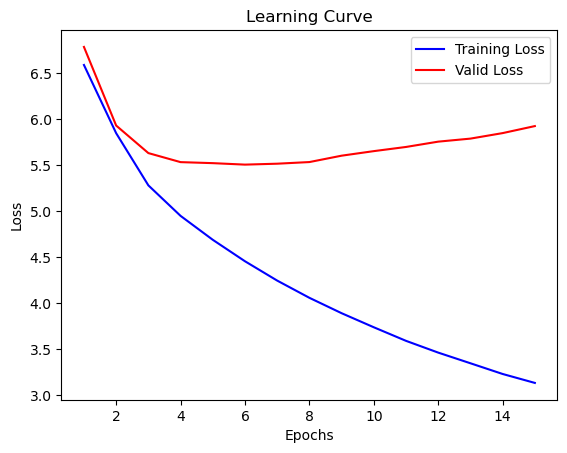

In [18]:
plot(lstm_loss_history, lstm_total_epochs)

##### Saving the Model

In [19]:
torch.save({'model_state_dict': lstm_model.state_dict(),
            'epoch': lstm_total_epochs,
            'optimizer_state_dict': lstm_optimizer.state_dict(),
            'loss_history': lstm_loss_history,
            'scheduler_state_dict': lstm_scheduler.state_dict()}, '/kaggle/working/lstm_checkpoint.tar')

##### Loading parameters of model trained for 100 epochs
These model weights for the LSTM and Transformer are not currently available publicly

In [20]:
checkpoint = torch.load('/kaggle/input/model-weights/lstm_checkpoint.tar', map_location = device)

lstm_model.load_state_dict(checkpoint['model_state_dict'])
lstm_total_epochs = checkpoint['epoch']
lstm_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lstm_loss_history = checkpoint['loss_history']
lstm_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

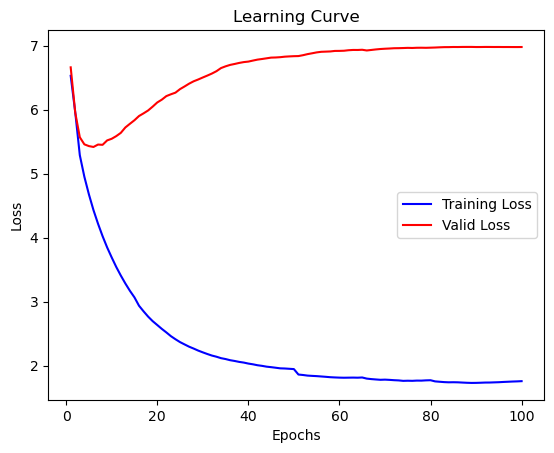

In [21]:
plot(lstm_loss_history, lstm_total_epochs)

Note that the validation loss decreases initially and then increases and settles at a point. The main reason may be due to overfitting in the training set. This overfitting may be due to insufficient amount of diversity in the poems of the training set. There also might be newer words in the validation set and with different themes and meanings. There could also be other reasons but after several introspections, this seemed the plausible explanation

## Transformer

#### Creating classes to implement the transformer

In [22]:
class PositionalEncoding(Module):
    def __init__(self, d_model: int, dropout: float = 0.1, seq_len: int = 512):
        super().__init__()
        self.dropout = Dropout(p=dropout)
        position = torch.arange(seq_len).unsqueeze(1)
        denominator = torch.pow(10000, torch.arange(0, d_model, 2)/d_model).unsqueeze(0)
        pe = torch.zeros(1, seq_len, d_model)
        pe[0, :, 0::2] = torch.sin(position/denominator)
        pe[0, :, 1::2] = torch.cos(position/denominator)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [23]:
class EncoderLayer(Module):
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1, batch_first: bool = True,
                 layer_norm_eps: float = 1e-5):
        
        super().__init__()
        self.mha = MultiheadAttention(d_model, nhead, dropout = dropout, batch_first = batch_first)
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.activation = ReLU()
        
    def forward(self, src: torch.Tensor, src_mask = None):
        
        x = src
        x, _ = self.mha(x, x, x, attn_mask = src_mask)
        x = self.dropout(x)
        norm1_output = self.norm1(x + src)
        
        x = self.linear1(norm1_output)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        norm2_output = self.norm2(x + norm1_output)
        
        return norm2_output

In [24]:
class Encoder(Module):    
    ##This encoder will be a bit different from the other encoders as in this implemented LM, we are using only the Encoder
    def __init__(self, num_layers: int, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                batch_first: bool = True, layer_norm_eps: float = 1e-5):
        
        super().__init__()
        self.layers = [EncoderLayer(d_model, nhead, dim_feedforward = dim_feedforward, dropout = dropout, batch_first = batch_first,
                                   layer_norm_eps = layer_norm_eps) for _ in range(num_layers)]
        for layer in self.layers:
            layer.to(device)
        self.num_layers = num_layers
        
    def forward(self, src: torch.Tensor, mask = None) -> torch.Tensor:
        
        output = src
        first_layer = self.layers[0]
        for mod in self.layers:
            output = mod(output, src_mask = mask)  
        
        return output

In [25]:
class LanguageModel(Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, nlayers: int, d_hid: int = 2048, dropout: float = 0.5, batch_first: bool = True):
        super().__init__()
        self.model_type = "Transformer"
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder.to(device)
        self.transformer_encoder = Encoder(nlayers, d_model, nhead, dim_feedforward = d_hid, dropout = dropout, batch_first = batch_first)
        self.transformer_encoder.to(device)
        self.embedding = Embedding(ntoken, d_model, padding_idx = tokenizer.pad_token_id)
        self.d_model = d_model
        self.linear = Linear(d_model, ntoken)
        self.activation = Softmax(dim = -1)
    
    def forward(self, src: torch.Tensor, src_mask = None) -> torch.Tensor:
        
        src = self.embedding(src)*math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        
        return output

    def generate_square_subsequent_mask(self, seq_len):
        mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

#### Setting up Transformer Model

In [26]:
transformer_model = LanguageModel(ntoken, d_model, nhead, nlayers, d_hid = d_hid, dropout = dropout, batch_first = True)
transformer_model.to(device)
for layer in transformer_model.transformer_encoder.layers:
    layer.to(device)

transformer_total_epochs = 0
transformer_loss_history = {'training_loss': [],
                'valid_loss': []}
print(transformer_model)

## Print Total Parameters
total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
for layer in transformer_model.transformer_encoder.layers:
    total_params += sum(p.numel() for p in layer.parameters() if p.requires_grad)
print("\nTotal Number of Parameters in Transformer Model = ", total_params)

LanguageModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): Encoder()
  (embedding): Embedding(50258, 256, padding_idx=50257)
  (linear): Linear(in_features=256, out_features=50258, bias=True)
  (activation): Softmax(dim=-1)
)

Total Number of Parameters in Transformer Model =  26969682


#### Setting up the optimizer and LR scheduler

In [27]:
transformer_criterion = CrossEntropyLoss()
lr = 0.001

parameters_list = list(transformer_model.parameters())
for layer in transformer_model.transformer_encoder.layers:
    parameters_list+= list(layer.parameters())
#parameters_list+= list(transformer_model.transformer_encoder.parameters())

transformer_optimizer = torch.optim.Adam(parameters_list, lr = lr)
transformer_scheduler = torch.optim.lr_scheduler.StepLR(transformer_optimizer, step_size = 1, gamma = 0.95)

#### Training the Transformer

In [28]:
epochs = 15
transformer_loss_history, transformer_total_epochs = train(transformer_model, transformer_optimizer, transformer_scheduler,
                                                           transformer_criterion, train_dataset, valid_dataset, epochs = epochs,
                                                           total_epochs = transformer_total_epochs, loss_history = transformer_loss_history)

| epoch   0 |   245/  490 batches | ms/batch 31.08 | loss 5.84388753 | ppl 345.11839 | valid_loss 5.55682439
| epoch   0 |   490/  490 batches | ms/batch 30.69 | loss 5.17999547 | ppl 177.68201 | valid_loss 5.33604589
| epoch   1 |   245/  490 batches | ms/batch 30.50 | loss 4.56700858 | ppl 96.25574 | valid_loss 5.25039013
| epoch   1 |   490/  490 batches | ms/batch 30.80 | loss 4.28610134 | ppl 72.68255 | valid_loss 5.32493716
| epoch   2 |   245/  490 batches | ms/batch 30.84 | loss 4.03263220 | ppl 56.40920 | valid_loss 5.35440793
| epoch   2 |   490/  490 batches | ms/batch 30.65 | loss 3.81531753 | ppl 45.39117 | valid_loss 5.48186255
| epoch   3 |   245/  490 batches | ms/batch 30.49 | loss 3.73418173 | ppl 41.85376 | valid_loss 5.46277343
| epoch   3 |   490/  490 batches | ms/batch 30.72 | loss 3.55892423 | ppl 35.12539 | valid_loss 5.55352728
| epoch   4 |   245/  490 batches | ms/batch 30.84 | loss 3.55556268 | ppl 35.00751 | valid_loss 5.55780532
| epoch   4 |   490/  490 

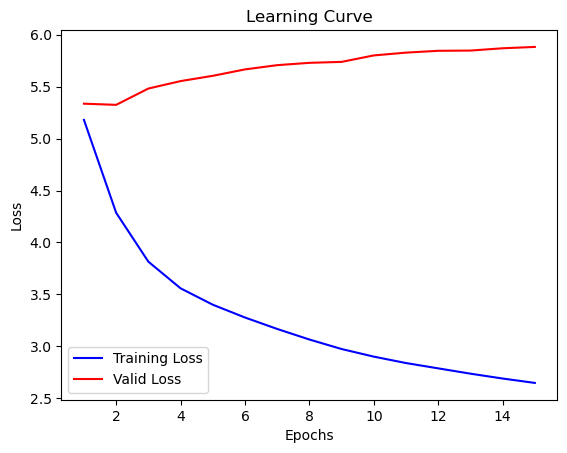

In [29]:
plot(transformer_loss_history, transformer_total_epochs)

#### Saving the model

In [30]:
checkpoint = {'model_state_dict': transformer_model.state_dict(),
            'epoch': transformer_total_epochs,
            'optimizer_state_dict': transformer_optimizer.state_dict(),
            'loss_history': transformer_loss_history,
            'scheduler_state_dict': transformer_scheduler.state_dict()}
for i, layer in enumerate(transformer_model.transformer_encoder.layers):
    checkpoint[f'encoder_layer_{i}'] = layer.state_dict()
    
torch.save(checkpoint, '/kaggle/working/transformer_checkpoint.tar')

##### Load the model that was trained for 100 epochs

In [31]:
checkpoint = torch.load('/kaggle/input/model-weights/transformer_checkpoint.tar', map_location = device)

transformer_model.load_state_dict(checkpoint['model_state_dict'])
transformer_total_epochs = checkpoint['epoch']
transformer_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
transformer_loss_history = checkpoint['loss_history']
transformer_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
for i, layer in enumerate(transformer_model.transformer_encoder.layers):
    layer.load_state_dict(checkpoint[f'encoder_layer_{i}'])

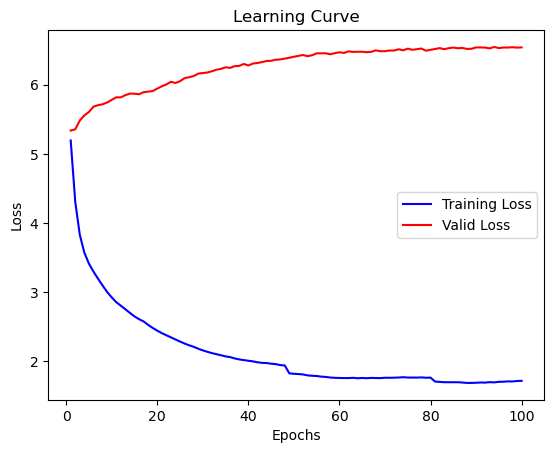

In [32]:
plot(transformer_loss_history, transformer_total_epochs)

We have the same kind of explanation for the Transformer model as well as to why the validation loss has increased

#### Sampling
Function to sample a poem given initial words. Word limit is currently set to 256, it can be changed as per user's choice.


In [33]:
def sample(model, words, n_words = 256):
    x = tokenizer(words, is_split_into_words = False)['input_ids']
    poem = x[:seq_len]
    if len(x)<seq_len:
        x += [tokenizer.pad_token_id for _ in range(seq_len-len(x))]
    if len(x)>seq_len:
        x = x[:seq_len]
    
    with torch.no_grad():
        for i in range(n_words):
            output = model(torch.LongTensor(x).unsqueeze(0).to(device))[:, -1, :]
            preds = np.asarray(output.cpu()).astype('float64')
            exp_preds = np.exp(preds)
            preds = (exp_preds / np.sum(exp_preds)).squeeze()
            probs = np.random.multinomial(1, preds, 1)
            out = np.random.choice(range(ntoken), p = probs.ravel())
            if out==tokenizer.eos_token_id:
                break
            x.append(out)
            x = x[1:]
            poem.append(out)
        print(tokenizer.decode(poem))

##### Sample using LSTM Model

In [34]:
sample(lstm_model, "Far west, beyond the ocean, there is a land")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Far west, beyond the ocean, there is a land,
His prealteus doe Ant seedly seed;

But that I grieve to find my truth their eyes
My love were I have dead,
Stella amate the bareeing well;
    Theyly death's Cynthia one and blide,
         We loved out, and Adam's glory, a thraw, 
Is an entangledoure, utterlyitors,
Or not it, by that once take Cblen Tied thine how time with my feeble self,
Gast or call thing to my bed,
And some us drift of dust again;
She sits to thieves in black stands else to nature hell deeds.

Whose other have th' enchanted will) spent sweetend below?
Yet you is ourselves.


##### Sample using Transformer Model

In [35]:
sample(transformer_model, "Far west, beyond the ocean, there is a land")

Far west, beyond the ocean, there is a land-.
Their she your cryingd:aide summer smold-Mary;
His face, lead a may.
To all friends in fresh, his early knighthood!" from your skies,
And all-head,
Stella, in clear relations heres which no suchaporous eaves,
But as he, his beard and faithful love's eye,
Athaca, as come and heavy bale, his lovely face paleth.
His death and me with them to the signs his coming,
And ready, and the me the world in loves,
That tree
That first years, and now mine own sacrifice a school boys and in the firm soil hath taught his good;
I could agree;
That men desire is gain come out where a spirit,
That away,
I only hills I have tops that shall have often prov'd to the Spring, before the thing constant light,
Let us still peace,
Through hollow lands and the hands on that first fro. And merry Larke to the pure ivyce
Her who will ye do as at his because.
And thou winter to be fay
